# <center> Monte Carlo Simulation: Stock Price Forecast </center>

In this notebook, I will forecast the price of Intel Corporation over 60 days. I will use a Monte Carlo simulation to generate different random walk predictions of Intel's price. The historical data will be divided in two sets; the first one will be the training data and will contain approximate 10 years of daily prices. The second set will be a test sample of the last 60-day prices of the stock; then, I will compare the results of the Monte Carlo simulation and te test dataset to evaluate accuarcy and draw conclusions. 

Let's start by importing all the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


I will also define helpful variables that will use later to scrap and plot the relevant data. 

In [2]:
stock = 'INTC' #Stock ticker symbol
start = '2010-1-1' #Start of the period for the analysis

#Dictionaries to customize the font of labels and titles
label_dict = {'fontsize': 14,
            'fontweight' : 5,
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'
             }
title_dict = {'fontsize': 20,
           'fontweight' : 5,
           'verticalalignment': 'baseline',
           'horizontalalignment': 'center'
             }


Now, I will import the data from yahoo finance using the <code>pandas_datareader</code> library to import the price data. In this case, I will use the Adjusted Close price because this takes into account changes due to stock splits, reverse splits and dividends.

In [3]:
data = pd.DataFrame()
data[stock] = wb.DataReader(stock, data_source = 'yahoo', start = start)['Adj Close']
    
data.head()

,INTC
Date,
2010-01-04,15.063472
2010-01-05,15.056260
2010-01-06,15.005755
2010-01-07,14.861475
2010-01-08,15.027405


Let's take a look to the relevant information of the data set. As noted below, there are 2,727 observations; all of these ones are float type and there are no null values; thus, we don't need to perform any transformation or adjustment to our data set.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2727 entries, 2010-01-04 to 2020-10-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INTC    2727 non-null   float64
dtypes: float64(1)
memory usage: 42.6 KB


Let's plot the historical price in a line chart. The stock has an upward long-term trend that started by beginning 2013. However, we can see the impact of Covid crash at the beginning of 2020 followed by a notable recovery that lasted few months. By July 2020, the stock fell considerable again after the company dropped its revenue forecasts for Q3-2020 and announced delays on new products. 

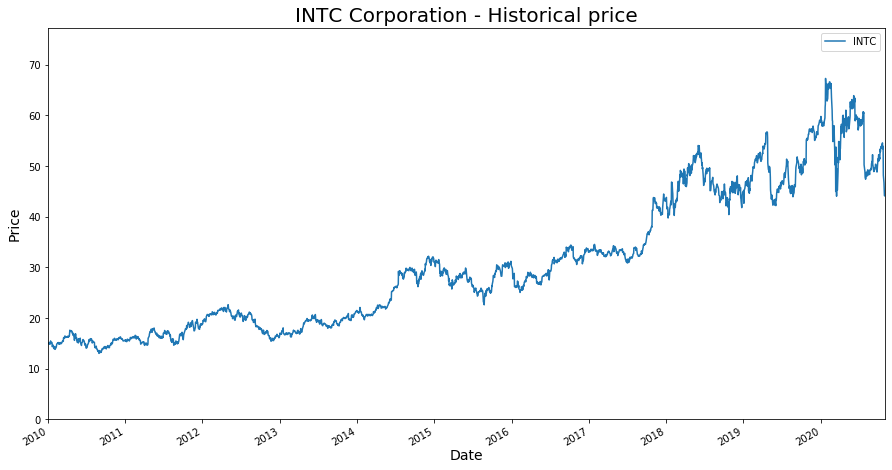

In [5]:
data.plot(xlim=(start,data.index.max()),ylim=(0,data.values.max()+10),figsize=(15,8))

plt.title(stock + ' Corporation - Historical price', fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Date', labelpad = 12, fontdict = label_dict)

plt.show()

The next step will be to divide our data set into two samples. I will call <code>data_train</code> to the training set that will help to fit the model to make the forecast, and the <code>data_test</code> will be used as a control to evaluate the accuracy of the prediction.

In [6]:
data_train = data.iloc[:-60]
data_test = data.iloc[-60:]

Now, let's calculate the daily returns of the stock. I will use the natural logarithm of the returns because the trend of the stock is an exponential growth rather than just linear. The method <code>pct_change</code> will be helpful to calculate the percentual change in the data series. 

In [7]:
Returns = np.log(data_train.pct_change()+1)
Returns.head()

,INTC
Date,
2010-01-04,NaN
2010-01-05,-0.000479
2010-01-06,-0.003360
2010-01-07,-0.009662
2010-01-08,0.011103


Taking a look to the graph of the returns, we could see that the mean over the period is relatively stable and constant. In the same manner, the volatility of the stock fluctuates in an specific range although there are some spikes these are outliers. Based on this analysis, we can conclude that the returns of the stock follow a normal distribution with an stable mean. This is a relevant conclusion because means that a Brownian Movement can be implemented.

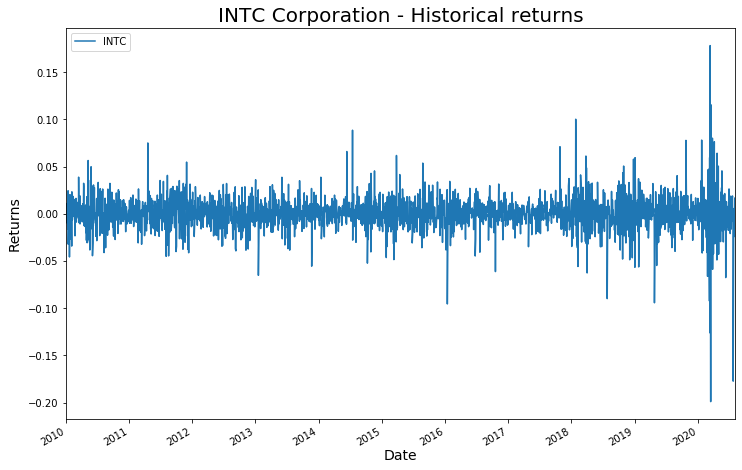

In [8]:
Returns.plot(xlim=(start,Returns.index.max()), figsize=(12,8))

plt.title(stock + ' Corporation - Historical returns', fontdict= title_dict)
plt.ylabel('Returns', labelpad = 10, fontdict = label_dict)
plt.xlabel('Date', labelpad = 12, fontdict = label_dict)

plt.show()

## Brownian movement

The Brownian motion model assumes that the price of the stock follows a random walk which basica implies that future movements of the price are not related with the past because all information available from the past is already incorporated (weak form of efficient markets hypothesis). 

The matemathical representation of the current stock price will be equal to the price of the stock one period before times the natural logarithm of the returns of the share. This natural logarithm of the returns follows a random process; therefore, we could use the Brownian motion to define it. 

The term $\mu - \frac{1}{2}\sigma^2$ represents the drift by what the stock is expected to go up; the second term, $\sigma*Z(Rand(0;1))$, is a random shock that will chage the drift either up or down.

\begin{equation*}
\large{Price\ today = Price\ yesterday *  e ^ {\mu - \frac{1}{2}\sigma^2 + \sigma * Z(Rand(0;1))}}
\end{equation*} 

Let's take a look to the mean and standard deviation of the returns.

In [9]:
Mu = Returns.mean()
print(f'The expected return is: %.6f' %Mu[0])

The expected return is: 0.000439


In [10]:
var = Returns.var()
std = Returns.std()
print(f'The variance of the returns is %.5f'%var[0]+' and the standard deviation is %.4f'%std[0])

The variance of the returns is 0.00032 and the standard deviation is 0.0179


With these two parameters, I can calculate the drift component based on the definition above and the following formula:

\begin{equation*}
\large{Drift = \mu - \frac{1}{2}\sigma^2}
\end{equation*} 

In [11]:
drift = Mu - 1/2*var
print(f'The drift component is %.5f'%drift[0])

The drift component is 0.00028


I have all the elements needed to run the model. Now, it is the time to run the Monte Carlo simulation. I will generate 50 random trials of the model. This means that I will create 50 different posible returns for the following 60 days. Let's define this into two variables.

In [12]:
t_interval = 60
iterations_1 = 50

Let's create a matrix of daily returns that will be fitted with the 50 iterations of the Brownian model.

In [13]:
daily_returns = np.exp(np.array(drift) + 
                       np.array(std) * norm.ppf(np.random.rand(t_interval,iterations_1)))
daily_returns

array([[1.028661  , 0.95616264, 1.00642591, ..., 0.99299154, 0.99050827,
        0.98207043],
       [0.99872177, 0.99496977, 0.97902369, ..., 1.03746484, 0.98376377,
        0.96588952],
       [0.99696549, 0.97586088, 1.01100437, ..., 0.98308446, 0.97887237,
        0.99279521],
       ...,
       [0.95871705, 1.00810475, 1.02641362, ..., 1.00474995, 1.01183515,
        1.00836292],
       [1.02240172, 1.03279985, 1.00250884, ..., 0.9983028 , 1.02755176,
        1.01048017],
       [0.97939752, 0.99338003, 0.9858026 , ..., 0.9923501 , 0.98501944,
        1.01737617]])

The array above contains all the different predictions of returns. Let's make sure that the result is a matrix of dimension $60$ x $50$.

In [14]:
daily_returns.shape

(60, 50)

Until here, we only have predicted returns. The stock price can be calcualted using the chain rule; we will need the stock price of the last period to forecast one period ahead, with this forecast, then, we can calculate the second period and so on until forecasting the 60th period. Let's assign <code>S0</code> as the price of the last period.

In [15]:
S0 = data.iloc[-1]
print(f"Intel's lats price is $%.2f"%S0[0])

Intel's lats price is $44.28


And create a matrix that will store the predicted prices. The dimensions of this matrix has to be the same as the daily returns matrix $60$ x $50$. Let's beging assigning zeros to this matrix.

In [16]:
price_list = np.zeros_like(daily_returns)
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The first row of the matrix will correspond to the last price of the stock which will be <code>S0</code> for each iteration.

In [17]:
price_list[0] = S0
price_list

array([[44.27999878, 44.27999878, 44.27999878, ..., 44.27999878,
        44.27999878, 44.27999878],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Now, it is the time to fill the rest of the matrix with the forecast of each iteration. As mention before, this will be done using the chain rule for forecasting time series, multiplying the prior stock price times the current return. 

In [18]:
for t in range(1,t_interval):
    price_list[t] = price_list[t-1] * daily_returns[t]

price_list

array([[44.27999878, 44.27999878, 44.27999878, ..., 44.27999878,
        44.27999878, 44.27999878],
       [44.22339888, 44.05725999, 43.35116773, ..., 45.93894171,
        43.56105832, 42.76958695],
       [44.08920252, 42.9937567 , 43.82821986, ..., 45.16185973,
        42.6407164 , 42.4614409 ],
       ...,
       [39.284211  , 43.32109018, 51.5200015 , ..., 46.11117147,
        38.53366419, 47.60874874],
       [40.16424485, 44.74201556, 51.64925675, ..., 46.0329115 ,
        39.5953346 , 48.10769642],
       [39.33676188, 44.44582486, 50.91597146, ..., 45.68076426,
        39.00217437, 48.94362416]])

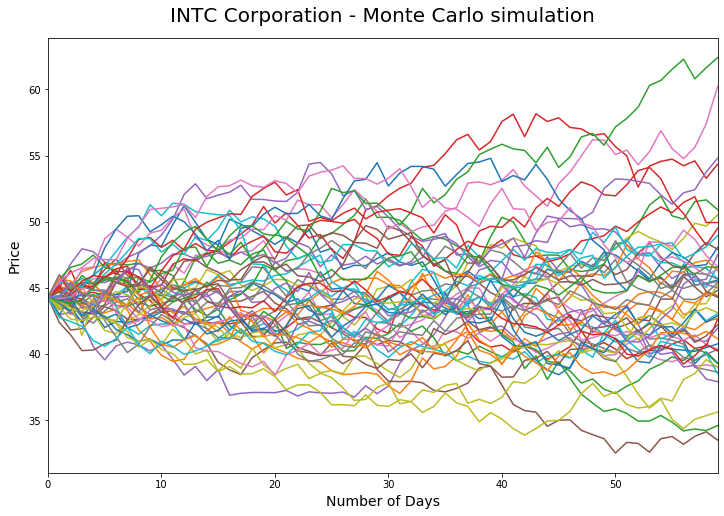

In [19]:
plt.figure(figsize=(12,8))
plt.plot(price_list)

plt.xlim(left = 0,right = t_interval-1)
plt.title(stock  + ' Corporation - Monte Carlo simulation',pad = 16, fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Number of Days', labelpad = 16, fontdict = label_dict)

plt.show()

In [21]:
df = pd.DataFrame(price_list)
df1 = pd.concat([pd.DataFrame(df[i].values, columns=[stock]) for i in range(len(df.columns.values))],ignore_index=True)
df1.describe()

,INTC
count,3000.000000
mean,44.490715
std,4.086050
min,32.527856
25%,41.815186
50%,44.232145
75%,46.730030
max,62.389945


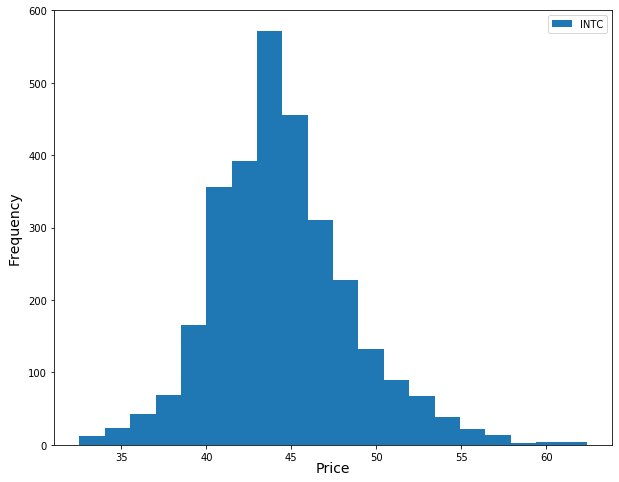

In [22]:
df1.plot.hist(figsize=(10,8),bins=20)
plt.xlabel('Price',labelpad = 10,fontdict = label_dict)
plt.ylabel('Frequency',labelpad = 10,fontdict = label_dict)
plt.show()

In [23]:
pred_price = []

for i in range(1,t_interval):
    pred_price.append(price_list[i].mean())


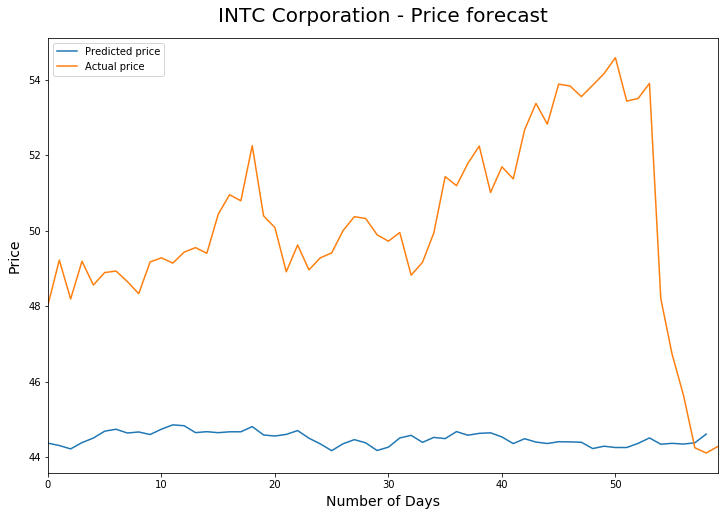

In [24]:
plt.figure(figsize=(12,8))
plt.plot(pred_price,label='Predicted price')
plt.plot(data_test.values,label='Actual price')

plt.xlim(left = 0,right = t_interval-1)
plt.title(stock + ' Corporation - Price forecast',pad = 16, fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Number of Days', labelpad = 16, fontdict =label_dict)

plt.legend()
plt.show()

_References:_

- https://www.cnbc.com/2020/07/23/intel-intc-earnings-q2-2020.html
- https://www.investopedia.com/articles/07/montecarlo.asp
- https://www.investopedia.com/terms/r/randomwalktheory.asp


